### Look at first run results

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import imageio
import glob
import matplotlib.path as mpath
import cmocean

In [2]:
# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [3]:
def prepare_plot(figsize=(15, 8)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig, ax = plt.subplots(1,2, figsize=figsize, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    for axis in ax.ravel():
        axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        axis.set_boundary(map_circle, transform=axis.transAxes)
        # ax.coastlines(); 
        gl = axis.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [3]:
mesh  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240123-filledlakes.nc').isel(time_counter=0)
fileT_ini = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/run1yr_rnf_icb_bdy-tra-ice/' + \
                            'eANT025.L121_1m_19790101_19791231_grid_T.nc')

In [5]:
tmask = np.ma.masked_where(mesh.tmask.values==0, mesh.tmask.values)

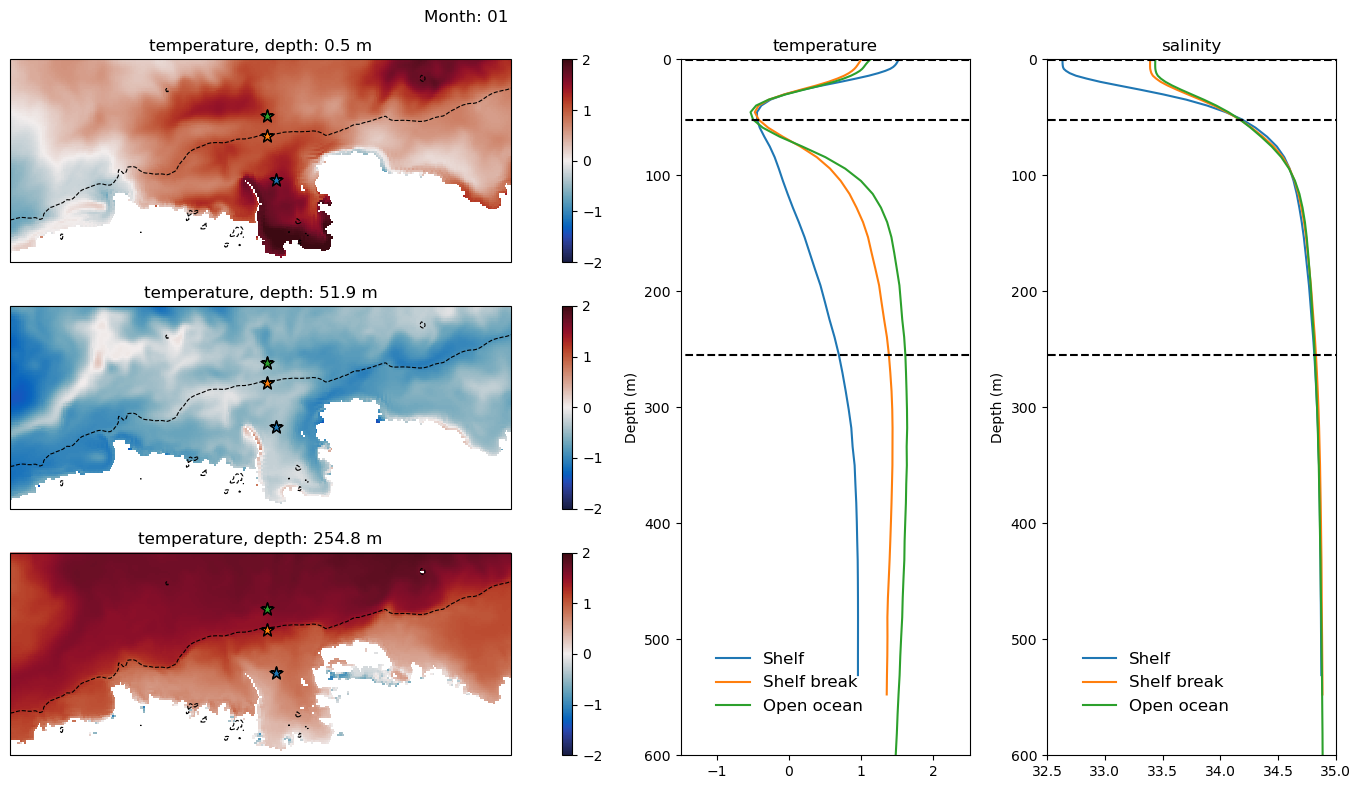

In [16]:
# before generalizing to animation, make single frame figures:
var='thetao'
month=1
depth_ind = [0, 18, 35]
fileT    = fileT_ini.isel(x_grid_T=slice(500, 900), y_grid_T=slice(150,350))
mesh_sub = mesh.isel(x=slice(500, 900), y=slice(150,350))

# --------- figure -------------------------------------------------------------
fig = plt.figure(figsize=(18,8))
fig.suptitle(f'Month: {month:02}')
gs = fig.add_gridspec(3,5)

ax1 = fig.add_subplot(gs[0, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
ax2 = fig.add_subplot(gs[1, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
ax3 = fig.add_subplot(gs[2, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
ax4 = fig.add_subplot(gs[:, 3]) # temperature
ax5 = fig.add_subplot(gs[:, 4]) # salinity

vm = [(-2, 2),(-2,2),(-2,2)] # colorbar limits
# Coordinates of 'stations'
i1, i2 = (249, 715) # on Amundsen shelf
s1, s2 = (271, 711) # Amundsen shelf break
o1, o2 = (281, 711) # off Amundsen slope
lon    = mesh.nav_lon.values
lat    = mesh.nav_lat.values

# --- Maps ---
kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}
for i, axis in enumerate([ax1, ax2, ax3]):
    axis.set_extent([-80, -140, -75.5, -68], ccrs.PlateCarree())
    axis.set_title(f'{fileT[var].long_name}, depth: {mesh.nav_lev.values[depth_ind[i]]:.1f} m')
    lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lon_grid_T.values)
    lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lat_grid_T.values)
    plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT[var].isel(time_counter=0, deptht=depth_ind[i]).values)
    cm = axis.pcolormesh(lon_plot, lat_plot, plot_var, vmin=vm[i][0], vmax=vm[i][1], **kwags1)

    # mark shelf break with dashed line
    axis.contour(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, mesh_sub.bathy_metry, [1200], 
                 linestyles='--', linewidths=0.8, colors='k', transform=ccrs.PlateCarree(), zorder=3)

    stn_kwags = {'transform':ccrs.PlateCarree(), 'marker':'*', 's':90, 'zorder':3, 'edgecolors':'k'}
    axis.scatter([lon[i1,i2], lon[i1,i2]], [lat[i1,i2], lat[i1,i2]], **stn_kwags)
    axis.scatter([lon[s1,s2], lon[s1,s2]], [lat[s1,s2], lat[s1,s2]], **stn_kwags)
    axis.scatter([lon[o1,o2], lon[o1,o2]], [lat[o1,o2], lat[o1,o2]], **stn_kwags)
    CB1 = fig.colorbar(cm, ax=axis, fraction=0.04)

# --- profiles ---
ax4.set_xlim(-1.5, 2.5)
ax5.set_xlim(32.5, 35)
vars = ['thetao', 'so']
for i, axis in enumerate([ax4, ax5]):
    axis.invert_yaxis()
    axis.set_ylim(600, 0)
    plot1 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2) == 0, np.nan, 
                     fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2))
    plot2 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2) == 0, np.nan, 
                     fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2))
    plot3 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2) == 0, np.nan, 
                     fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2))
    axis.set_title(fileT_ini[vars[i]].long_name)
    axis.plot(plot1, mesh.nav_lev, label='Shelf')
    axis.plot(plot2, mesh.nav_lev, label='Shelf break')
    axis.plot(plot3, mesh.nav_lev, label='Open ocean')
    
    for di in depth_ind:
        axis.plot([-10, 40],[mesh.nav_lev.values[di], mesh.nav_lev.values[di]], '--k')
    axis.set_ylabel('Depth (m)')
    axis.legend(frameon=False, loc=(0.1, 0.05), fontsize=12)

fig.tight_layout()

In [13]:
def plot_2D_circumpolar(depth, path='.'):

    for month in range(0,12):
        kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':-4, 'vmax':4}
        kwags2  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.haline, 'rasterized':True, 'vmin':33, 'vmax':35.5}
        fig, ax = prepare_plot()
        cm1 = ax[0].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=month, deptht=depth), **kwags1)
        cm2 = ax[1].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.so.isel(time_counter=month, deptht=depth), **kwags2)
        CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04)
        CB1.set_label(fileT.thetao.long_name)
        CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04)
        CB2.set_label(fileT.so.long_name)
        fig.suptitle(f'Month: {month+1}, depth: {mesh.nav_lev.values[depth]:.1f} m');
    
        fig.savefig(f'{path}circumpolar_m{month+1:02}z{depth:03}.jpg', bbox_inches='tight')

    return

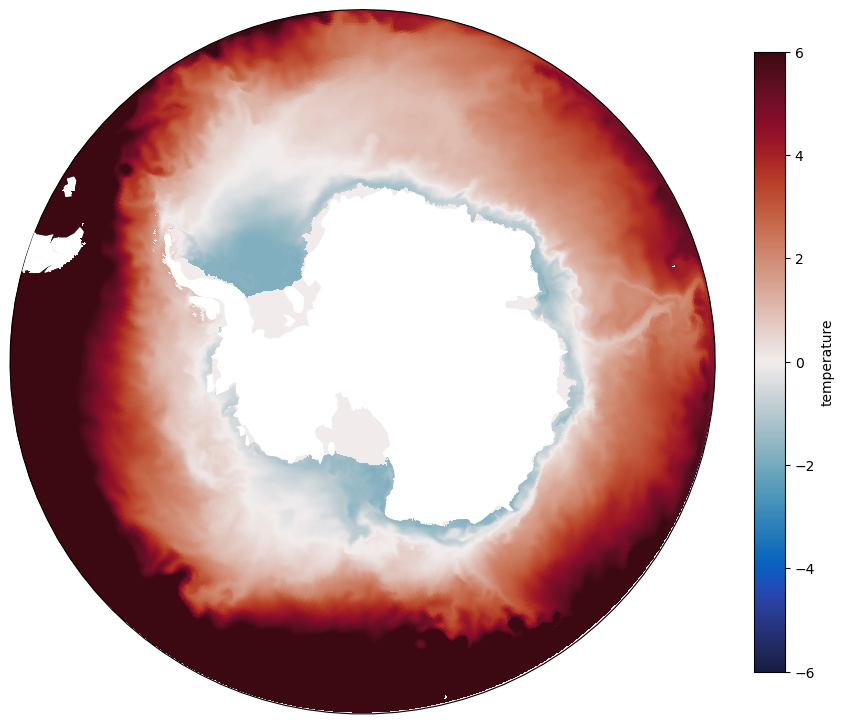

In [7]:
kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':-6, 'vmax':6}

fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_boundary(map_circle, transform=ax.transAxes)
cm1 = ax.pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=2, deptht=0), **kwags1)
ax.add_feature(cfeature.LAND, color='w', zorder=3)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
CB1.set_label(fileT.thetao.long_name)

In [7]:
def plot_2D_Amundsen(depth, path='.'):

    for month in range(0,12):
        kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':-4, 'vmax':4}
        kwags2  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.haline, 'rasterized':True, 'vmin':33, 'vmax':35.5}
        fig, ax = prepare_plot()
        cm1 = ax[0].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=month, deptht=depth), **kwags1)
        cm2 = ax[1].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.so.isel(time_counter=month, deptht=depth), **kwags2)
        CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04)
        CB1.set_label(fileT.thetao.long_name)
        CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04)
        CB2.set_label(fileT.so.long_name)
        fig.suptitle(f'Month: {month+1}, depth: {mesh.nav_lev.values[depth]:.1f} m');
    
        fig.savefig(f'{path}amundsen_m{month+1:02}z{depth:03}.jpg', bbox_inches='tight')


    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':0, 'vmax':2}
    fig, ax = plt.subplots(1,1, figsize=(10,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
    ax.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
    
    cm1 = ax.pcolormesh(icemod.nav_lon, icemod.nav_lat, icemod.sithic.isel(time_counter=2), **kwags1)
    ax.add_feature(cfeature.LAND, color='w', zorder=3)
    
    # CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
    # CB1.set_label(fileT.thetao.long_name)

    return

In [10]:
def create_animation(depth, filenames, out_file='test.mp4'):
    
    # filenames is a list of the names/locations of image files to combine into animation (mp4 in this case)
    with imageio.get_writer(f'{out_file}', fps=4, mode='I') as writer: 
        for filename in filenames:  
            image = imageio.imread(filename)  
            writer.append_data(image)
    return

In [ ]:
for depth in [0, 20, 50, 80, 100]:
    run_path = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/run1yr/'
    plot_2D_circumpolar(depth, path=run_path)
    filenames=glob.glob(f'{run_path}circumpolar_m??z{depth:03}.jpg')
    create_animation(depth, filenames, out_file=f'{run_path}circumpolar_monthly_z{depth:03}.mp4')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
    cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                      colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=31, vmax=34)
# CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')